In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torch.utils.data.dataloader import DataLoader
import itertools
from torchtext.vocab import Vocab
from torch.utils.data.dataset import Dataset, TensorDataset
from pathlib import Path
from collections import Counter
from langdetect import detect

from torchtext import data   

UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
SPECIAL_TOKENS = [UNKNOWN_TOKEN, PAD_TOKEN]

<font size=5>
LSTM model
</font>

In [2]:
class DataReader:
    # Read input file and get sentence
    def __init__(self, file_path, words_dict):
        self.file_path = file_path
        self.words_dict = words_dict
        self.get_sentences()
    
    def sentence_to_list_of_nums(self, sentence):
        words = sentence.split()
        new_sentence = [self.words_dict[x] if x in self.words_dict else self.words_dict[UNKNOWN_TOKEN] for x in words]
        return new_sentence
    
    def get_sentences(self):
        df = pd.read_csv(self.file_path)
        df['text'] = df['text'].apply(lambda x:self.sentence_to_list_of_nums(x))
        self.labels = list(df['label'])
        self.sentences = list(df['text'])
        

In [3]:
class parseDataset(Dataset):
    def __init__(self, word_dict, file, padding=False, word_embeddings=None):
        super().__init__()
        self.file = file
        self.datareader = DataReader(self.file, word_dict)
        self.word_vocab_size = len(self.datareader.words_dict)
  
        if word_embeddings:
            self.word_idx_mappings, self.idx_word_mappings, self.word_vectors = word_embeddings
        else:
            self.word_idx_mappings, self.idx_word_mappings, self.word_vectors = self.init_word_embeddings(word_dict)

        #self.unknown_idx = self.word_idx_mappings.get(UNKNOWN_TOKEN)
        self.word_vector_dim = self.word_vectors.size(-1)
        
        self.sentence_lens = [len(sentence) for sentence in self.datareader.sentences]
        self.max_seq_len = max(self.sentence_lens)
        self.sentences_dataset = self.convert_sentences_to_dataset(padding)

    def __len__(self):
        return len(self.sentences_dataset)
    
    def __getitem__(self, index):
        word_embed_idx,label = self.sentences_dataset[index]
        return word_embed_idx, label

    @staticmethod
    def init_word_embeddings(word_dict):
        glove = Vocab(Counter(word_dict), vectors="glove.6B.100d", specials=SPECIAL_TOKENS)
        return glove.stoi, glove.itos, glove.vectors
    
    def get_word_embeddings(self):
        return self.word_idx_mappings, self.idx_word_mappings, self.word_vectors

    def convert_sentences_to_dataset(self, padding):
        sentence_word_idx_list = []
        sentence_len_list = []
        labels = []
        for i in range(len(self.datareader.sentences)):
            words_idx_list = self.datareader.sentences[i]
            label = self.datareader.labels[i]
            sentence_len = len(words_idx_list)
            sentence_word_idx_list.append(torch.tensor(words_idx_list, dtype=torch.long, requires_grad=False))
            labels.append(torch.tensor(label, dtype=torch.float, requires_grad=False))
            sentence_len_list.append(sentence_len)
    
        return {i: sample_tuple for i, sample_tuple in enumerate(zip(sentence_word_idx_list,
                                                                     labels))}

In [4]:
class LSTM(nn.Module):
    def __init__(self, word_embeddings, word_embedding_dim, hidden_dim, word_vocab_size):
        super(LSTM, self).__init__()
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=False)
        self.emb_dim = word_embedding_dim
        self.lstm = nn.LSTM(input_size=word_embedding_dim,bidirectional=False, hidden_size=hidden_dim, num_layers=1,batch_first=True )
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sentence):
        word_idx_tensor = sentence
        word_embeds = self.word_embedding(word_idx_tensor) #.to(self.device))
        output, (hidden,_) = self.lstm(word_embeds)
        hidden = hidden.view(-1)
        out = self.fc(hidden)
        out =  self.sigmoid(out)
        return out, word_embeds

In [5]:
import pickle
with open('words_dict_subjectivity2.pkl', 'rb') as f:
    words_map = pickle.load(f)
with open('words_dict_embedding_subjectivity2.pkl', 'rb') as f:
    weights_matrix = pickle.load(f)

In [6]:
WORD_EMBEDDING_DIM = 100
HIDDEN_DIM = 100
word_vocab_size = len(words_map)
model = LSTM(weights_matrix, WORD_EMBEDDING_DIM, HIDDEN_DIM, word_vocab_size)
model.load_state_dict(torch.load('subjictivity_model2'))

<All keys matched successfully>

In [7]:
import string
def sentences_to_score(sentences):
    scores_list = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        words = sentence.split()
        len_sentence = len(words)
        if len_sentence == 0:
            scores_list.append([0.5,0.5])
            continue
        new_sentence = [words_map[x] if x in words_map else words_map[UNKNOWN_TOKEN] for x in words]
        new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
        score,_ = model(new_sentence)
        score = score.data.tolist()[0]
        scores_list.append([1-score,score])
    return np.array(scores_list)

<font size=5>
Model explainers
</font>

In [8]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
def lime_explainer(sentence):
    explainer = LimeTextExplainer(bow=True)
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    exp = explainer.explain_instance(sentence, sentences_to_score,num_features=100)
    lime_dict = dict(exp.as_list())
    words = sentence.split()
    lime_scores = []
    for word in words:
        if word in lime_dict:
            lime_scores.append(lime_dict[word])
        else:
            lime_scores.append(0)
    return lime_scores


In [9]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
def lime_explainer_plot(sentence):
    explainer = LimeTextExplainer(bow=True)
    exp = explainer.explain_instance(sentence, sentences_to_score,num_features=100)
    exp.as_pyplot_figure()

In [10]:
import string
import numpy as np
def Saliency_explainer_norm(sentence):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    len_sentence = len(words)
    new_sentence = [words_map[x] if x in words_map else words_map[UNKNOWN_TOKEN] for x in words]
    new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
    score,embeds = model(new_sentence)
    model.train()
    model.zero_grad()
    gradients = torch.autograd.grad(outputs=score, inputs=embeds)
    gradients_numpy = gradients[0][0].detach().numpy()
    norms = np.linalg.norm(gradients_numpy,axis=1)
    return norms
    

In [13]:
import math
def erase_explainer(sentence):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    len_sentence = len(words)
    new_sentence = [words_map[x] if x in words_map else words_map[UNKNOWN_TOKEN] for x in words]
    new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
    score,_ = model(new_sentence)
    score_full_sentence = score.data.tolist()[0]
    erase_score = []
    for word in words:
        new_sentence = [words_map[x] if (x!=word and x in words_map) else words_map[UNKNOWN_TOKEN] for x in words]
        new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
        score,_ = model(new_sentence)
        erase_score.append(score_full_sentence-score.data.tolist()[0])
    return erase_score
    

In [14]:
def sort_words_by_scores(scores,words_list):
    return [x for _,x in sorted(zip(scores,words_list),reverse=True)]

In [15]:
def weights_list_to_dict(weights,words):
    saliency_map = {}
    for i,word in enumerate(words):
        saliency_map[word] = weights[i]
    return {k: v / max(saliency_map.values(),key=abs) for k, v in saliency_map.items()}

In [16]:
def positive_liklihood(sentence):
    prob = sentences_to_score([sentence])[0,1]
    print('Probability(Subjective) =', prob)
    return prob

In [17]:
import matplotlib.pyplot as plt
def subcategorybar(words, list_of_explainer_scores,labels, width=0.8):
    n = len(list_of_explainer_scores)
    _X = np.arange(len(words))
    plt.figure(figsize=(15,7))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, list_of_explainer_scores[i], 
                width=width/float(n), align="edge",label=labels[i])   
    plt.xticks(_X, words,rotation=30)
    plt.legend()

In [18]:
def sentence_explainers_plot(sentence):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    positive_liklihood(sentence)
    lime_scores = lime_explainer(sentence)
    abs_lime = [abs(score) for score in lime_scores]
    normalized_lime = [score/sum(abs_lime) for score in abs_lime]
    Saliency_scores = Saliency_explainer_norm(sentence)
    normalized_saliency = [score/sum(Saliency_scores) for score in Saliency_scores]
    erase_scores = erase_explainer(sentence)
    abs_erase = [abs(score) for score in erase_scores]
    normalized_erase = [score/sum(abs_erase) for score in abs_erase]
    subcategorybar(words, [normalized_saliency,normalized_lime,normalized_erase],['Saliency','Lime','Erase'])

Probability(Subjective) = 0.9339046478271484


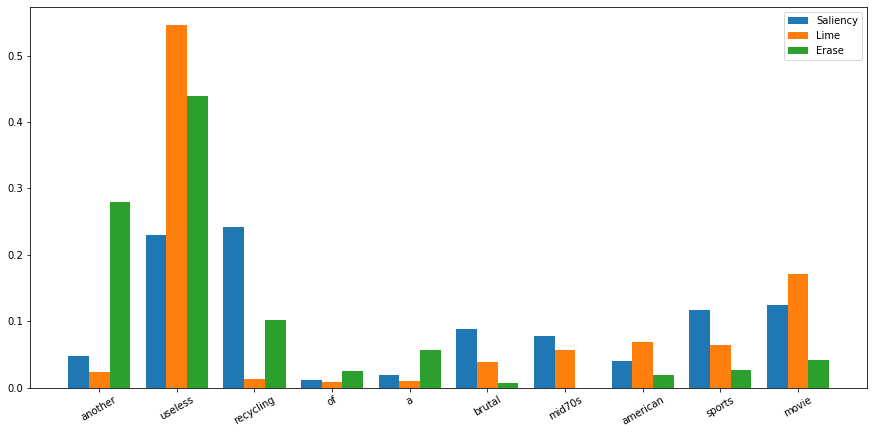

In [19]:
sentence_explainers_plot("another useless recycling of a brutal mid70s american sports movie")

Probability(Subjective) = 0.9877814054489136


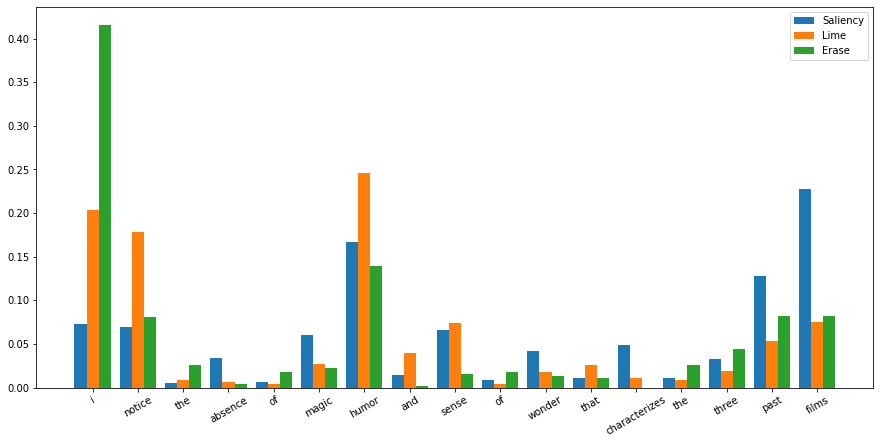

In [20]:
sentence_explainers_plot("I notice the absence of magic, humor and sense of wonder that characterizes the three past films")

Probability(Subjective) = 0.012940721586346626


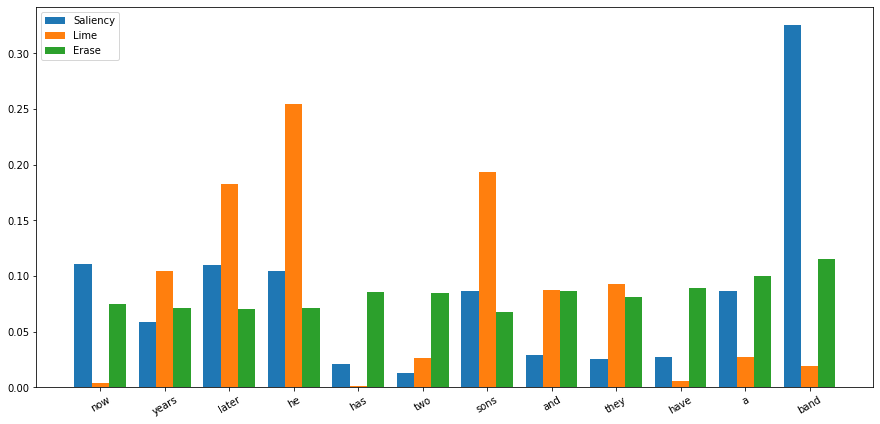

In [21]:
sentence_explainers_plot("now  years later he has two sons and they have a band  ")

Probability(Subjective) = 0.000791832513641566


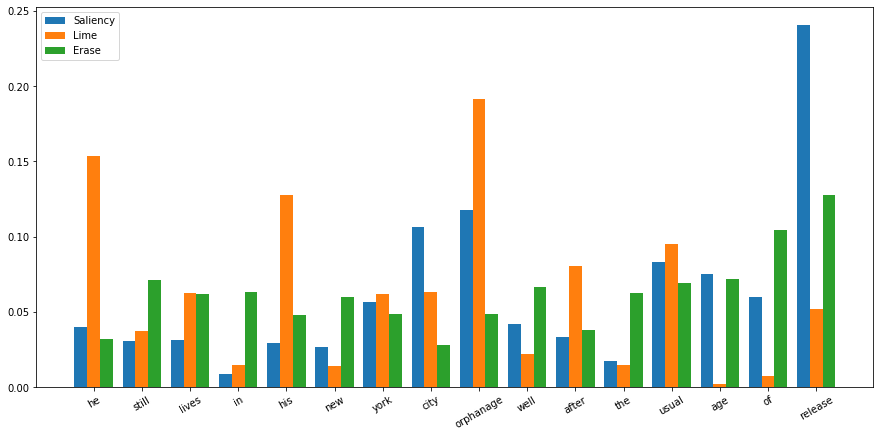

In [22]:
sentence_explainers_plot("he still lives in his new york city orphanage well after the usual age of release")

In [23]:
test = pd.read_csv('subjectivity_test.csv')
all_=0
true=0
for _,row in test.iterrows():
    sentence = row['text']
    label = row['label']
    print(sentence)
    prob = positive_liklihood(sentence)
    print(label)
    if label==round(prob):
        true+=1
    all_+=1
    print()

leaving her successful career and las vegas forever in order to build her family in a healthy environment was since long prevented by katherine hiller  barbara carrera   her discoverer and business manager 
Probability(Subjective) = 0.00011214904952794313
0

stranded on hawaii  experiment 626 cant actually do much harm  water all around  no big cities and two wellequipped representatives of the galactic federation already following close behind to catch him again 
Probability(Subjective) = 0.004489914979785681
0

a film thats flawed and brilliant in equal measure 
Probability(Subjective) = 0.9924848675727844
1

magneto  having escaped from his plastic prison  forms an unlikely alliance with professor xavier to stop stryker 
Probability(Subjective) = 1.4682221262773965e-05
0

it provides the grand  intelligent entertainment of a superior cast playing smart people amid a compelling plot 
Probability(Subjective) = 0.9972285628318787
1

set in 1986 when best friends harry  olsen  and lloyd

Probability(Subjective) = 0.9886781573295593
1

it offers little beyond the momentary joys of pretty and weightless intellectual entertainment 
Probability(Subjective) = 0.9875808954238892
1

but what exactly is good and waht exactly is evil 
Probability(Subjective) = 0.16564300656318665
0

the mystery of enigma is how a rich historical subject  combined with so much firstrate talent    could have yielded such a flat  plodding picture 
Probability(Subjective) = 0.9987875819206238
1

the story follows mirabelle  a disenchanted salesgirl and aspiring artist who sells gloves and accessories at neiman marcus 
Probability(Subjective) = 3.730277967406437e-05
0

speaking in terms of spectacle  craft  romance and humor  its the movie to beat this summer 
Probability(Subjective) = 0.953389585018158
1

it is bad  but certainly not without merit as entertainment 
Probability(Subjective) = 0.9846968650817871
1

its all entertaining enough  but dont look for any hefty antiestablishment message in w

after military service in the gulf war and the former yugoslavia  he returned to his inner city neighborhood to teach at the toughest school in town 
Probability(Subjective) = 6.145988299977034e-05
0

biker cary ford is framed by and old rival and biker gang leader for the murder of another gang member who happens to be the brother of trey  ice cube   leader of the most feared biker gang in the country 
Probability(Subjective) = 0.0003424860187806189
0

its hard to recognize change when youre in the middle of it college follows a young man in his final semester of college as he segues into adult life 
Probability(Subjective) = 0.007609386462718248
0

after an attempt is made on his life by unknown gunmen  whom he kills them all using martal arts skills he didnt know he had  he learns that all of his dreams of a past life are real and that for the past three years he was raised by the couple after finding him in a river  halfdead with five bullet wounds in him 
Probability(Subjective) =

although the dogs seemingly have it in for ted  he decides to keep the dogs and race them in the local race  the arctic challenge  spiting a mountain man  played by james coburn  who wants the dogs 
Probability(Subjective) = 0.0002961061254609376
0

a mix of gritty realism  crisp storytelling and radiant compassion that effortlessly draws you in 
Probability(Subjective) = 0.9844236969947815
1

lives hang in the balance as they scramble to unravel the mystery and protect the student body from their own hatred and fear 
Probability(Subjective) = 0.0011007928987964988
0

both undauntedly take a sardonic  actionpacked jaunt with plenty of gunplay and intrigue with an unforgettable cast of characters after markos trusting wife ashe  robyn adamsom  discovers that these two deviants of social behavior have bet her entire life savings of 3  000 bucks on an nba playoff game 
Probability(Subjective) = 0.014917585067451
0

an undistinguished attempt to make a classic theater piece cinematic 
Prob

Probability(Subjective) = 0.959686279296875
1

lando  frustrated with isabels conservatism and idealism  turns his attention to clara  which irked isabel 
Probability(Subjective) = 3.741536056622863e-05
0

sparkles in its deft portrait of tinseltowns seasoned veterans of gossip  wealth  paranoia  and celebrityhood 
Probability(Subjective) = 0.9952391386032104
1

after six months at sea on an unassisted solo circumnavigation  georgia perrys 44foot sloop is becalmed for several days 
Probability(Subjective) = 0.0006944510387256742
0

a man brutally beats his girlfriend to death and tosses her remains into a local river   
Probability(Subjective) = 5.4911000916035846e-05
0

little is done to support the premise other than fling gags at it to see which ones shtick 
Probability(Subjective) = 0.9969569444656372
1

this is snappy  frothy screwball comedy awash in french understatement 
Probability(Subjective) = 0.9993664622306824
1

the two join forces to find out who wants her dead and why 


an entertaining and topical adventure drama which responds to our societys fascination with doomsday cults  survivalist sects and their messianic leaders 
Probability(Subjective) = 0.4993866980075836
0

a crisply made movie that is no more than mildly amusing 
Probability(Subjective) = 0.9998370409011841
1

those who love him today risk being heartbroken tomorrow   
Probability(Subjective) = 0.01076599583029747
0

in an effort  i suspect  not to offend by appearing either too serious or too lighthearted  it offends by just being wishywashy 
Probability(Subjective) = 0.9994692206382751
1

a librarian begins a passionate affair with a mysterious woman who walks into his library 
Probability(Subjective) = 8.465146675007418e-05
0

but at one point finch and stifler put their differences aside and hold a huge party for jim  the night before his wedding 
Probability(Subjective) = 0.0008451294270344079
0

a movie where story is almost an afterthought amidst a swirl of colors and inexplicable 

confusion is one of my least favourite emotions  especially when i have to put up with 146 minutes of it 
Probability(Subjective) = 0.6462963819503784
1

empire cant make up its mind whether it wants to be a gangster flick or an art film  it doesnt work as either 
Probability(Subjective) = 0.997515082359314
1

according to eric and amis passiveaggressive mother who refuses to accept that her daughter is an adult  jessica walters   that answer is  yes  
Probability(Subjective) = 0.002450426109135151
0

this charming  thoughtprovoking new york fest of life and love has its rewards 
Probability(Subjective) = 0.5471539497375488
1

if the first men in black was money  the second is small change  but it still jingles in the pocket  its fun lite 
Probability(Subjective) = 0.8793303966522217
1

i have to admit i walked out of runteldat  i did go back and check out the last 10 minutes  but these were more repulsive than the first 30 or 40 minutes 
Probability(Subjective) = 0.9756699204444885
1


starting off small  dealing to the high school and college market  kilo discovers the drug business to be very profitable 
Probability(Subjective) = 0.018055148422718048
0

part contemporary investigation and part historical inquiry  documentary follows the quest of one journalist in search of justice 
Probability(Subjective) = 0.002103653270751238
0

the elders bikes are unfortunately backed over at the post office and they end up bumming a ride with an older but kindly man 
Probability(Subjective) = 0.004742016550153494
0

a recess in a wall  as for holding a statue 
Probability(Subjective) = 0.036443885415792465
0

the appearance of treebeard and gollums expanded role will either have you loving what youre seeing  or rolling your eyes  i loved it  gollums performance is incredible 
Probability(Subjective) = 0.9955769777297974
1

johnny lever  paaji  is a millionaire sardarji who believes in distributing 38  spending lavishly his wealth on his friends 
Probability(Subjective) = 0.000

as he chases the elusive bounty hunter  jango  and his cloned son boba  leads obi wan to geonosis  where he meets count dooku and finds a startling revelation about the former jedi 
Probability(Subjective) = 0.00031690517789684236
0

raimi crafted a complicated hero who is a welcome relief from the usual twodimensional offerings 
Probability(Subjective) = 0.9964446425437927
1

or so he tells bobby  alex feldman  the eighteen year old male hustler smith employs for company 
Probability(Subjective) = 0.0021673948504030704
0

this temporary city is the 6th largest in nevada 
Probability(Subjective) = 0.0003030516963917762
0

underachieves only in not taking the shakespeare parallels quite far enough 
Probability(Subjective) = 0.9623086452484131
1

the judge gives him until the end of the day to present the papers and thus begins a cat and mouse game between the proponents 
Probability(Subjective) = 0.00017340089834760875
0

it is said that only salazar slytherins true descendent will be a

Probability(Subjective) = 0.9996638298034668
1

and a lyrical portrait of the everpresent guardians who preserve lifes natural harmony 
Probability(Subjective) = 0.6218913793563843
0

a mythic motorcycle tale of father and son   this is the story of manuel galloway  fishburne   also known as  the king of cali   the president of a motorcycle club whose members are all africanamerican men  mostly whitecollar workers who exchange their suits and ties at night and on weekends for leather outfits and motorcycle helmets 
Probability(Subjective) = 0.00014840652875136584
0

they are five cinderellas in search of prince charming and a new chance in life 
Probability(Subjective) = 0.0025671415496617556
0

a team of scientists is recruited in a crash project to send a ship and bomb into the center of the earth to prevent the catastrophe 
Probability(Subjective) = 5.327984763425775e-05
0

as their adopted identity grows  the gang tumbles into a downward spiral of excitement  excess and fun 
Probab

  analyze that  is one of those crass  contrived sequels that not only fails on its own  but makes you secondguess your affection for the original 
Probability(Subjective) = 0.9960827827453613
1

and so he does  at the risk of exposing the ugly truth beneath his false facade 
Probability(Subjective) = 0.028678666800260544
0

john takes off  his trust in the system diminishing rapidly 
Probability(Subjective) = 0.004299759399145842
0

its like a vintage automobile that sometimes runs smoothly  and sometimes lurches and sputters  but it never quite stalls 
Probability(Subjective) = 0.9829619526863098
1

director duncan roy impressively presents aka through three simultaneous frames rather than one  offering the audience a deeper and more complex perspective through which to view deans engrossing story 
Probability(Subjective) = 0.9832128882408142
0

in the surroundings of the bookstore  a lot of criminal  but also funny activities take place 
Probability(Subjective) = 0.7730734944343567


and thats the trickits a gay cruiseliner for gay men to make out 
Probability(Subjective) = 0.1281891018152237
0

when the fire burns out  weve only come facetoface with a couple dragons and thats where the film ultimately fails 
Probability(Subjective) = 0.2743210196495056
1

after returning home from a two week trial in chicago  rachel bishop  rachel nord  finds her sister emily bishop  nancy walters  missing 
Probability(Subjective) = 5.533214789466001e-05
0

its lazy for a movie to avoid solving one problem by trying to distract us with the solution to another 
Probability(Subjective) = 0.995762825012207
1

the film narrates in a richly detailed  associative montage the boundless possibilities of manipulating images and using images to seduce 
Probability(Subjective) = 0.6743505597114563
0

its a subtle mood piece in which a mans collapse is examined so rigorously that one almost hopes for a murder to come along and break the tension 
Probability(Subjective) = 0.9900000691413879
1


boasting the best swordfighting sequences to hit the screen in many years  it is so enjoyably oldfashioned it even looks as if it were made in the 70s 
Probability(Subjective) = 0.9745538830757141
1

a winning crowdpleaser with more than enough juice to crossover with fans of all stripes  regardless of whether they even know anything about soccer or not 
Probability(Subjective) = 0.417025089263916
1

after witnessing a horrific and traumatic event  julia lund  laura regan   a graduate student in psychology  gradually comes to the realization that everything which scared her as a child could be real 
Probability(Subjective) = 0.0003787229070439935
0

a skillfully made example of your typical schwarzenegger action film 
Probability(Subjective) = 0.9706949591636658
1

asia authors herself as anna battista  an italian superstar and aspiring directress who just happens to be her own worst enemy 
Probability(Subjective) = 0.00010018870671046898
1

kamel  a young man from the french ghetto  n

Probability(Subjective) = 0.0004489162238314748
0

the movie has lots of dancing and fabulous music  there are slow and repetitive parts  but it has just enough spice to keep it interesting 
Probability(Subjective) = 0.9981093406677246
1

this rough trade punchandjudy act didnt play well then and it plays worse now 
Probability(Subjective) = 0.8769729137420654
1

it is so refreshing to see robin williams turn 180 degrees from the string of insultingly innocuous and sappy fiascoes hes been making for the last several years 
Probability(Subjective) = 0.9562245607376099
1

the film jolts the laughs from the audienceas if by cattle prod 
Probability(Subjective) = 0.9995250701904297
1

photographed with melancholy richness and eloquently performed yet also decidedly uncinematic 
Probability(Subjective) = 0.9979875087738037
1

sometimes makes less sense than the bruckheimeresque american action flicks it emulates 
Probability(Subjective) = 0.9994258880615234
1

while cherish doesnt completel

Probability(Subjective) = 0.00029237460694275796
0

i know that ill never listen to marvin gaye or the supremes the same way agai
Probability(Subjective) = 0.8835108876228333
1

resurrection has the dubious distinction of being a really bad imitation of the really bad blair witch project 
Probability(Subjective) = 0.9964078068733215
1

windtalkers is shapelessly gratifying  the kind of movie that invites you to pick apart its faults even as you have to admit that somehow it hit you where you live 
Probability(Subjective) = 0.9898161888122559
1

a smug and convoluted actioncomedy that doesnt allow an earnest moment to pass without reminding audiences that its only a movie 
Probability(Subjective) = 0.995514452457428
1

he has already written the script but does not have the means of financing his project 
Probability(Subjective) = 0.9407410621643066
0

tobacks fondness for fancy splitscreen  stuttering editing and pompous references to wittgenstein and kirkegaard    blends uneasily with

Probability(Subjective) = 0.17131780087947845
0

how do you make a movie with depth about a man who lacked any  on the evidence before us  the answer is clear  not easily and  in the end  not well enough 
Probability(Subjective) = 0.9917145371437073
1

until one day  renata adhiswara  rachel maryam  came into his world 
Probability(Subjective) = 0.00023468337894883007
0

what jackson has accomplished here is amazing on a technical level 
Probability(Subjective) = 0.935941755771637
1

shortly hereafter she encounters dieter  a charming young man 
Probability(Subjective) = 0.0009160945774056017
0

like being trapped inside a huge video game  where exciting  inane images keep popping past your head and the same illogical things keep happening over and over again 
Probability(Subjective) = 0.45203837752342224
1

a modest pleasure that accomplishes its goals with ease and confidence 
Probability(Subjective) = 0.9925722479820251
1

no better or worse than truth or consequences  n  m   or any

the ingenuity that parker displays in freshening the play is almost in a class with that of wilde himself 
Probability(Subjective) = 0.9585107564926147
1

on the day a young photographer is moving out of his place to live with his girlfriend  he meets the stunning girl moving in and falls in love with her at first sight 
Probability(Subjective) = 0.00014069957251194865
0

a serial killer is on the loose and kills herberts assistant  dan cain 
Probability(Subjective) = 0.0002244771458208561
0

when starla figures out that genevieve deliberately set it up by giving her bad tutoring to fail all those classes  she begins an allout personal war against genevieve to take back her social life 
Probability(Subjective) = 0.0004672643553931266
0

inherently caustic and oddly whimsical  the film chimes in on the grieving process and strangely draws the audience into the unexplainable pain and eccentricities that are attached to the concept of loss 
Probability(Subjective) = 0.9976094961166382
1



before long  the bay boy of bowls is turning the sedate and very english pastime upside down with hysterical results 
Probability(Subjective) = 0.35816138982772827
0

like carlos and mickey  sean and eddie are best friends 
Probability(Subjective) = 0.005000775214284658
0

russian ark moves beyond a simple technical exercise and into the realm of greatness  its a masterpiece on every level 
Probability(Subjective) = 0.9872007369995117
1

the teen must decide whether to become immortal and stay with a tuck shes fallen in love with 
Probability(Subjective) = 0.025076260790228844
0

shot perhaps artistically with handheld cameras and apparently no movie lights by joaquin bacaasay  the lowbudget production swings annoyingly between vertigo and opacity 
Probability(Subjective) = 0.14087659120559692
1

its not an important picture  and probably not even a memorable one  but i had a good time 
Probability(Subjective) = 0.9952617883682251
1

veras technical prowess ends up selling his film sho

its a much more emotional journey than what shyamalan has given us in his past two movies  and gibson  stepping in for bruce willis  is the perfect actor to take us on the trip 
Probability(Subjective) = 0.9973715543746948
1

instead of using george and lucys most obvious differences to ignite sparks  lawrence desperately looks elsewhere  seizing on georges haplessness and lucys personality tics 
Probability(Subjective) = 0.1329544633626938
1

not a bad choice here  assuming that    the airconditioning in the theater is working properly 
Probability(Subjective) = 0.9605341553688049
1

the problem with movies about angels is they have a tendency to slip into hokum  a rumor of angels doesnt just slip  it avalanches into forced fuzziness 
Probability(Subjective) = 0.998267650604248
1

they persevere and in the end a startling surprise bubbles to the surface that changes everything 
Probability(Subjective) = 0.2081340253353119
0

nick farrow is a young midtwenties trust fund baby 
Probabil

Probability(Subjective) = 0.9940224289894104
1

many a parent and their teen  or preteen  kid could bond while watching a walk to remember  so could young romantics out on a date 
Probability(Subjective) = 0.007389997597783804
1

when fowler introduces pyle to his beautiful young vietnamese mistress phuong  hai yen  the three become swept up in a tempestuous love triangle that leads to a series of startling revelations and finally  murder 
Probability(Subjective) = 0.0001528564898762852
0

the two wind up in a deserted warehouse where they witness a diamond scam in action  caught in the midst they put their differences aside to team up and detain the looters 
Probability(Subjective) = 2.8914968424942344e-05
0

theres no disguising this as one of the worst films of the summer  or for the year  for that matter 
Probability(Subjective) = 0.9753937721252441
1

when it comes to entertainment  children deserve better than pokemon 4ever 
Probability(Subjective) = 0.9970640540122986
1

four fr

Probability(Subjective) = 0.0015855032252147794
0

poor ben bratt couldnt find stardom if mapquest emailed him pointtopoint driving directions 
Probability(Subjective) = 0.2929283380508423
1

the soviet union has collapsed and armenia is on the verge of her independence 
Probability(Subjective) = 0.0011135415406897664
0

its somewhat clumsy and too lethargically paced  but its story about a mysterious creature with psychic abilities offers a solid buildup  a terrific climax  and some nice chills along the way 
Probability(Subjective) = 0.9889072179794312
1

an intense and effective film about loneliness and the chilly anonymity of the environments where so many of us spend so much of our time 
Probability(Subjective) = 0.9885927438735962
1

chalk it up to my adoration for both de niro and murphy  but i had a pretty good time with this movie  despite its myriad flaws 
Probability(Subjective) = 0.9997856020927429
1

writerdirector dante tomaselli merges two disturbing storylines into thi

wendigo wants to be a monster movie for the arthouse crowd  but it falls into the trap of pretention almost every time 
Probability(Subjective) = 0.9830648303031921
1

according to wendigo  nature loves the members of the upper class almost as much as they love themselves 
Probability(Subjective) = 0.31969648599624634
1

before the investigation ends  weve met boyfriends  a drug dealer  alicias mom  hadleys dad  nurses  doctors  and an orderly 
Probability(Subjective) = 4.301203807699494e-05
0

too bad kramer couldnt make a guest appearance to liven things up 
Probability(Subjective) = 0.9582973122596741
1

mother and daughter hide in the  panic room   a secret room designed for just such a purpose  but still end up fighting for their lives   
Probability(Subjective) = 0.002632860792800784
0

often a capable documentary on an interesting subject  even if it doesnt probe as deeply as it could 
Probability(Subjective) = 0.9908850789070129
1

  its like those monster vampire high school k

its valuable message makes it a mustsee for children and teenagers  and even more so for those callous adults who have become casually corrupt in their efforts to simply get through life 
Probability(Subjective) = 0.8025034070014954
1

john quincy archibalds son michael collapses while playing baseball as a result of a heart failure 
Probability(Subjective) = 4.8714489821577445e-05
0

a film at once depressing and upliftingdepressing in terms of the sad  often horrifying subjects of nachtweys photographs but uplifting in terms of his commitment and integrity 
Probability(Subjective) = 0.9763062596321106
1

in a summer overrun with movies dominated by cgi aliens and super heroes  it revigorates the mind to see a feature that concentrates on people  a project in which the script and characters hold sway 
Probability(Subjective) = 0.9833390712738037
1

in a revealing and often hilarious portrait  mary dispenses homespun wisdom while divulging family secrets and rivalries 
Probability(Subj

Probability(Subjective) = 0.03714323043823242
0

despite its shortcomings  girls cant swim represents an engaging and intimate first feature by a talented director to watch  and its a worthy entry in the french comingofage genre 
Probability(Subjective) = 0.9883604049682617
1

makes the same mistake as the music industry it criticizes  becoming so slick and watereddown it almost loses what made you love it in the first place 
Probability(Subjective) = 0.5761658549308777
1

soon discovering that theyre in a strange fourth dimension where our laws of physics dont apply  they have to unravel the secrets of the  hypercube  in order to survive   
Probability(Subjective) = 0.012309351935982704
0

her scholarship and her dreams are on the line and jenny takes an emotional roller coaster ride on the path to work it out 
Probability(Subjective) = 0.001721294247545302
0

the word in las vegas is that he is dead 
Probability(Subjective) = 0.025206640362739563
0

a morality tale whose thoughtprovo

Probability(Subjective) = 0.7669888734817505
1

for those in search of something different  wendigo is a genuinely bonechilling tale 
Probability(Subjective) = 0.5129976272583008
1

straight up  helicopters in action will take audiences on a series of aerial adventures 
Probability(Subjective) = 0.2735833525657654
0

will she get it  or will death get her first 
Probability(Subjective) = 0.01921572908759117
0

as alex begins to dictate his tale of a romantic love triangle to the charming yet somewhat opinionated stenographer  emma challenges his ideas at every turn 
Probability(Subjective) = 0.0021081233862787485
0

susie is obsessed about losing weight  thus being  bonita  and not  gorda   the two keywords in the original spanish title 
Probability(Subjective) = 0.001891156192868948
0

and finds himself in the middle of two assassination plots masterminded by the cia 
Probability(Subjective) = 3.4538701584097e-05
0

woo has as much right to make a huge action sequence as any director 

by abstracting and showing extreme details and connecting routines with themes and emotions  liesbeth worm gives a whole new perspective on day to day life 
Probability(Subjective) = 0.006872725207358599
0

dizzy harrison is an unpopular  high school geek going through a hellish senior year 
Probability(Subjective) = 0.3815214931964874
0

when he was a young boy  kyle  chaney kley  claimed that while he was sleeping  he accidentally woke up and saw the tooth fairy  who tried to kill him 
Probability(Subjective) = 0.000619484344497323
0

fifteen years later  and their friendship has blossomed via email  raj believing that hes getting to know tina when its really pooja 
Probability(Subjective) = 0.0001320341689279303
0

as she makes her way through the dazed world of the citys junkies  only one person seems able to provide any help  the obsessive and selfdestructive miles  the last of the citys security officers 
Probability(Subjective) = 4.469168561627157e-05
0

astrid magnussen is a 12

you neednt be steeped in 50s sociology  pop culture or movie lore to appreciate the emotional depth of haynes work  though haynes style apes films from the period    its message is not rooted in that decade 
Probability(Subjective) = 0.9973005652427673
1

with his own group  the urban cyber breakers  he has got a dream  to win the dance battle that will bring his team to the world final in new york before reaching usa and fame  he has to overcome the rival group  the ld  to deal with his mothers excessive love and to live out his passion for the beautiful samia 
Probability(Subjective) = 6.592490535695106e-05
0

without blowing the jokes we can say that  if you have found that your sense of humor fit well with christopher guests screen outings  youll find yourself in the flow with shearer as well 
Probability(Subjective) = 0.9853029251098633
1

well  bruce nolan  played by jim carrey  gets that chance after he freaks out on live tv  is fired and is offered a new job by an unknown place

Probability(Subjective) = 0.0005200647283345461
0

with a cast of nonactors  drawn from the very world which the film portrays  shooters is not just another british genre gangster film  its a film about real british gangsters 
Probability(Subjective) = 0.2800931930541992
0

although their characters and temperaments couldnt be less alike  19year olds wei and jie are best friends 
Probability(Subjective) = 0.9019896388053894
0

like the best 60 minutes exposé  the film  at 80 minutes  is actually quite entertaining 
Probability(Subjective) = 0.9954622387886047
1

when the secret codes controlling a killer nuclear satellite are stolen by the worlds most dangerous criminal  americas best agent teams up with a brittish beauty to recover the codes in an endgame of action  betrayal and intrigue 
Probability(Subjective) = 0.0016795228002592921
0

this is an exercise not in biography but in hero worship 
Probability(Subjective) = 0.8732100129127502
1

thomas wish comes true and he stays up all

Probability(Subjective) = 0.005770931486040354
0

the actors are simply too good  and the story too intriguing  for technical flaws to get in the way 
Probability(Subjective) = 0.9868721961975098
1

her young son dies  her marriage to max is ruined  and her lover is in fact dangerous in his jealousy and mad rage  but no matter what the consequences  his subversive spirit lives inside her  forms her  obsesses her 
Probability(Subjective) = 0.0010313718812540174
0

ben stiller and jack black star as tim and nick  best friends  neighbors and coworkers  whose equal footing is suddenly tripped up when one of nicks harebrained getrichquick schemes actually succeeds  vapoorizer  a spray that literally makes dog poop  or any other kind for that matter  evaporate into thin air  to where exactly is anyones guess 
Probability(Subjective) = 0.004251123871654272
0

a kinetic drama that seems to wander aimlessly  beautifully until it crashes in an odd anticlimax befitting reality itself 
Probability

the ensuing road trip packs even more slapstick and locker room humor into an  alreadybursting  movie 
Probability(Subjective) = 0.9936187267303467
0

welcome to peoplemovin  com  a leader in americas transient workforce  more commonly known as temporary employment 
Probability(Subjective) = 0.3093380630016327
0

to protect her relationship with john  she  ditches  her son  having him arrested and locked in a correctional  mental  facility  before coercing her older brother burt  who lives in hollywood  to take him 
Probability(Subjective) = 0.004069689195603132
0

astonishing isnt the word  neither is incompetent  incoherent or just plain crap  indeed  none of these words really gets at the very special type of badness that is deuces wild 
Probability(Subjective) = 0.9959904551506042
1

this startling film provides a gritty look into american politics in the new south 
Probability(Subjective) = 0.9821227788925171
0

michael  sr  and michael  jr  then set out to get revenge on the man 

Probability(Subjective) = 0.8823314905166626
1

the doctor realizes its a love virus so he advises him to woo the girl somehow  not realizing that munnabhai has fallen for none other than his own younger sister komal 
Probability(Subjective) = 3.828620901913382e-05
0

the piquant story needs more dramatic meat on its bones 
Probability(Subjective) = 0.9831829071044922
1

much as we might be interested in gratuitous sexualization  haneke has a different objective in mindnamely the implications of our craving for fake stimulation 
Probability(Subjective) = 0.9997376799583435
1

they continue with all the same characteristics trademarks of the shinhyun serial killings 
Probability(Subjective) = 0.004602464847266674
0

people on the site work monotonously  in a fervor  then dazed  trancelike 
Probability(Subjective) = 0.02085692249238491
0

diane lane works nothing short of a minor miracle in unfaithful 
Probability(Subjective) = 0.5812734961509705
1

the sequel is everything the original 

as they become jaded by watching these brutal fights  and betting becomes boring  the bosses realize that they need to take the fights to a new limit 
Probability(Subjective) = 0.04197884351015091
0

his motives are plain and simple  to meet a woman 
Probability(Subjective) = 0.062042348086833954
0

its pithy without being saccharine  its funny without ever not taking itself seriously  its full of beautiful characters and great performances 
Probability(Subjective) = 0.9994296431541443
1

  pinkloving  blondehaired harvard law school graduate elle woods  witherspoon  returns in this sequel  as she turns her legal and fashionsavvy knowhow towards getting a bill passed through congress  relocating a second time  after adapting her beverly hills ways to harvard  and now   
Probability(Subjective) = 0.0003298805677331984
0

he returns with his wife  mercedes  an argentinean he met in spain  and his two adolescent children  mateo and cayetana  born in the same country and forced into a land

the story of mitchell  a tenyearold african american who lives with his mom in a crackinfested hotel in downtown l  a  mitchell misses the school bus one day and quickly becomes the property of chris  a suicidal drug dealer who might be losing his mind 
Probability(Subjective) = 0.0002910002658609301
0

price has to pretend he is also gay in order to stay hidden 
Probability(Subjective) = 0.1272849291563034
0

    a good film that must have baffled the folks in the marketing department 
Probability(Subjective) = 0.9993441700935364
1

with the machine they travel across the country  uruguay  traing to escape to brazil 
Probability(Subjective) = 9.876714466372505e-05
0

the film has the highbuffed gloss and highoctane jolts you expect of de palma  but what makes it transporting is that its also one of the smartest  most pleasurable expressions of pure movie love to come from an american director in years 
Probability(Subjective) = 0.9974326491355896
1

though the bosses killed his father

if youre like me  a sucker for a good old fashion romance and someone who shamelessly loves to eat  then mostly martha offers all the perfect ingredients to more than satisfy your appetite 
Probability(Subjective) = 0.9964885711669922
1

with david carradine  theo van gogh  kate clarke and henry jaglom  featuring a soundtrack by grammy nominated composer willie wisely  who also plays the lead character  willie vincent 
Probability(Subjective) = 0.0530824214220047
0

quirky and understated office comedy with crispin glover as the guy who would prefer not to work  but likes to hang around 
Probability(Subjective) = 0.9983579516410828
1

is it possible for a documentary to be utterly entranced by its subject and still show virtually no understanding of it 
Probability(Subjective) = 0.9869984984397888
1

first kammy meets the 40yearold danny  dave wong  and falls head over heels 
Probability(Subjective) = 0.00011126504250569269
0

drugs are out because they tried that before and some of th

Probability(Subjective) = 0.9996145963668823
1

that all changes when a teammate is mysteriously stabbed during a ball field brawl 
Probability(Subjective) = 4.291166260372847e-05
0

a haunted  bountiful film that demands patience  and rewards it 
Probability(Subjective) = 0.9609178304672241
1

using this violence as a springboard  bret begins a new game  a game where only he knows the rules 
Probability(Subjective) = 0.0003864380996674299
0

the egyptian queen cleopatra bets against the roman emperor  julius caesar  that her people are still great  even if the times of the pharaohs has long passed 
Probability(Subjective) = 0.00044267610064707696
0

the kind of film that grows on you upon reflectio
Probability(Subjective) = 0.9981654286384583
1

the worst pain for him is the next 5 minutes of living 
Probability(Subjective) = 0.06950605660676956
0

using two separate filmmaking teams  an allwhite crew filming white residents and an allblack camera crew filming black residents   two to

Probability(Subjective) = 0.9998626708984375
1

a young boy has been possessed so as to capture a young  beautiful girl 
Probability(Subjective) = 0.008308341726660728
0

jeffs has created a breathtakingly assured and stylish work of spare dialogue and acute expressiveness 
Probability(Subjective) = 0.26715853810310364
1

cinephiles will appreciate the fine camerawork and overall miseenscene  but people just heading out for a popcorn pleaser will likely be disappointed 
Probability(Subjective) = 0.9946948885917664
1

the bands courage in the face of official repression is inspiring  especially for aging hippies  this one included  
Probability(Subjective) = 0.7482292056083679
1

heartstopping talent doesnt seem to be enough when your parents want you to hang up your football boots  find a nice boyfriend and learn to cook the perfect chapatti 
Probability(Subjective) = 0.0014311824925243855
0

the super 16mm black and white film was shot in a remote farm in argentina 
Probability(Subjec

    flatout amusing  sometimes endearing and often fabulous  with a solid cast  noteworthy characters  delicious dialogue and a wide supply of effective sight gags 
Probability(Subjective) = 0.9995617270469666
1

she ultimately decides to pursue her lifelong dream of opening her own dance studio for innercity youths 
Probability(Subjective) = 0.007735783234238625
0

if it were any more of a turkey  it would gobble in dolby digital stereo  if nothing else   rollerball  2002 may go down in cinema history as the only movie ever in which the rest of the cast was outshined by ll cool j 
Probability(Subjective) = 0.9362435340881348
1

she is married to henry bauford  linus roache  son of a wealthy british industrialist  when she encounters nick callahan  clive owen  a renegade doctor  whose impassioned plea for help to support his relief efforts in wartorn africa moves her deeply 
Probability(Subjective) = 0.0002134352980647236
0

the longer the movie goes  the worse it gets  but its actuall

as they used to say in the 1950s scifi movies  signs is a tribute to shyamalans gifts  which are such that well keep watching the skies for his next project 
Probability(Subjective) = 0.34842944145202637
1

  brown sugar  admirably aspires to be more than another  best man  clone by weaving a theme throughout this funny film 
Probability(Subjective) = 0.9911050200462341
1

her mothers friends  who formed a secret society  the yaya sisterhood  as children  kidnap siddalee from her new york apartment and take her home to louisiana  where they explain why her mother mistreated her with help from the secret yaya scrapbook  and copious flashbacks  
Probability(Subjective) = 0.00014935283979866654
0

thanks to scotts charismatic roger and eisenbergs sweet nephew  roger dodger is one of the most compelling variations on in the company of men 
Probability(Subjective) = 0.1262408345937729
1

never engaging  utterly predictable and completely void of anything remotely interesting or suspenseful 

Probability(Subjective) = 0.00010736368858488277
0

though talk in the film often turns to death  khatras enthusiasm and love of life keep the movie surprisingly upbeat 
Probability(Subjective) = 0.9977806210517883
1

together with his men  mcnamara uses a heros resolve to carry out his mission  ultimately forced to weigh the value of his life against the good of his country 
Probability(Subjective) = 0.0005329600535333157
0

a new t 101 unit  arnold schwarzenegger  is also sent back to help john 
Probability(Subjective) = 0.34912174940109253
0

russian ark is a new treasure of the hermitage 
Probability(Subjective) = 0.05755431577563286
1

this gorgeous epic is guaranteed to lift the spirits of the whole family 
Probability(Subjective) = 0.9666533470153809
1

the film is an enjoyable family film  pretty much aimed at any youngster who loves horses 
Probability(Subjective) = 0.9997668862342834
1

but she cant escape her suspicion that her husband is having an affair with a teenage girl

an uncomfortable movie  suffocating and sometimes almost senseless  the grey zone does have a center  though a morbid one 
Probability(Subjective) = 0.9946749210357666
1

in the ensuing chaos  inez discovers the thorny side of true love and that finding ones soul mate is never quite what youd expect 
Probability(Subjective) = 0.004461230710148811
0

extreme oops  oops  ops  no matter how you spell it  its still a mistake to go see it 
Probability(Subjective) = 0.9601117968559265
1

disturbing for its unabashed honesty  our cast of characters both love and despise each other  their very actions acknowledging the pressures inherent in a tightly bonded peer group 
Probability(Subjective) = 0.9865068197250366
0

without de niro  city by the sea would slip under the waves  he drags it back  singlehanded 
Probability(Subjective) = 0.8208274841308594
1

flounders due to the general sense that no two people working on the production had exactly the same thing in mind 
Probability(Subjective) =

Probability(Subjective) = 0.012283176183700562
0

the nightmare isnt over  william birkin ordered the hive to be reopened  and in doing so contaminated all of raccoon city  a city of the daed  with alice stuck right in the middle 
Probability(Subjective) = 0.0007581074605695903
0

on the way back from the bargain  mary nearly runs over a caped  winged figure  jerks the wheel and skids into the sidewalk 
Probability(Subjective) = 6.405486783478409e-05
0

gambling and throwing a basketball game for money isnt a new plot  in fact toback himself used it in black and white  but tobacks deranged immediacy makes it seem fresh again 
Probability(Subjective) = 0.02248336188495159
1

there are some fairly unsettling scenes  but they never succeed in really rattling the viewer 
Probability(Subjective) = 0.9848928451538086
1

at the height of his tv career  chuck barris was recruited by the cia and trained to become a covert operative 
Probability(Subjective) = 2.7388141461415216e-05
0

with a com

Probability(Subjective) = 0.15916414558887482
0

is anyone else out there getting tired of the whole slomo  doublepistoled  ballisticpyrotechnic hong kong action aesthetic 
Probability(Subjective) = 0.8484863638877869
1

the body bears strange marks on the chest which may or may not be the sign of a sin eater  furmann   a renegade who offers absolution  last rites and therefore a path to heaven outside the jurisdiction of the church 
Probability(Subjective) = 0.00035869760904461145
0

facing her past  culturally and emotionally  eve finds herself caught up in the independent movement of armenia  and the crisis of commitment with the man whom she falls in love 
Probability(Subjective) = 0.0013248053146526217
0

hardly a masterpiece  but it introduces viewers to a good charitable enterprise and some interesting real people 
Probability(Subjective) = 0.9853917956352234
1

nicks  seemingly uncertain whats going to make people laugh  runs the gamut from stale parody to raunchy sex gags to f

the title trapped turns out to be a pretty fair description of how you feel while youre watching this ultramanipulative thriller 
Probability(Subjective) = 0.9987504482269287
1

a gardenfresh morality tale for the kids  with monty pythoninspired humor 
Probability(Subjective) = 0.9418699145317078
1

de niro may enjoy the same free ride from critics afforded to clint eastwood in the lazy bloodwork  but like bruce springsteens gonetopot asbury park  new jersey  this sadsack waste of a movie is a city of ruins 
Probability(Subjective) = 0.9991710186004639
1

reinalda fell hopelessly in love with her long red hair and big goodgoods during her days as a french panto teacher and now she will stop at nothing  including the highest office in the land  to be with her always 
Probability(Subjective) = 0.0009352588094770908
0

a great ensemble cast cant lift this heartfelt enterprise out of the familiar 
Probability(Subjective) = 0.9825299382209778
1

this is the sort of lowgrade dreck that usual

<font size=5>
Explainers evaluation - AOPC, discounted MORF
</font>

In [24]:
import math
def MoRF(sentence, order):
    new_sentence,words = tokenized_sentece(sentence)
    pertubated = [new_sentence]
    len_sentence = len(words)
    for word in order:
        words = [x if x!=word else UNKNOWN_TOKEN for x in words]
        new_sentence = [words_map[x] if x in words_map else words_map[UNKNOWN_TOKEN] for x in words]
        new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
        pertubated.append(new_sentence)
    return pertubated

In [25]:
def AOPC(pertubated, predictor):
    AOPC = 0
    for i in range(len(pertubated)):
        AOPC += abs(predictor(pertubated[0])[0].data.tolist()[0]- predictor(pertubated[i])[0].data.tolist()[0])
    return AOPC/(len(pertubated)+1)

In [26]:
def linear(x):
    return 1/x

def quadratic(x):
    return 1/(x**2)

def logarthmic(x):
    return 1/math.log(x)

In [27]:
def discounted_MoRF(sentence, order,predictor, discount_function=quadratic):
    summ = 0
    new_sentence,words = tokenized_sentece(sentence)
    counter = 1
    len_sentence = len(words)
    for word in order:
        pertubated_sentence = [words_map[x] if (x!=word and x in words_map) else words_map[UNKNOWN_TOKEN] for x in words]
        pertubated_sentence = torch.tensor(pertubated_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
        summ += discount_function(counter)*abs(predictor(new_sentence)[0].data.tolist()[0]- predictor(pertubated_sentence)[0].data.tolist()[0])
        counter += 1
    return summ

In [28]:
def tokenized_sentece(sentence):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    len_sentence = len(words)
    new_sentence = [words_map[x] if x in words_map else words_map[UNKNOWN_TOKEN] for x in words]
    new_sentence = torch.tensor(new_sentence, dtype=torch.long, requires_grad=False).view(1,len_sentence)
    return new_sentence, words

In [29]:
def get_explainers_scors_df(sentences):
    lime_lists = []
    erase_lists = []
    saliency_lists = []
    words_lists = []
    sentences_list = []
    for sentence in sentences:
        _,words = tokenized_sentece(sentence)
        lime_lists.append(lime_explainer(sentence))
        erase_lists.append(erase_explainer(sentence))
        saliency_lists.append(Saliency_explainer_norm(sentence))
        words_lists.append(words)
        sentences_list.append(sentence)
    df = pd.DataFrame({'sentence':sentences_list,'sentence_words':words_lists,'lime_scores':lime_lists,'erase_scores':erase_lists,'saliency_scores':saliency_lists})
    return df

In [30]:
def abs_normalize(scores):
    abs_scores = [abs(score) for score in scores]
    normalized_scores = [score/sum(abs_scores) for score in abs_scores]
    return normalized_scores

In [31]:
def abs_normalize_df(explainers_df):
    explainers_df['lime_scores'] = explainers_df['lime_scores'].apply(lambda x:abs_normalize(x))
    explainers_df['erase_scores'] = explainers_df['erase_scores'].apply(lambda x:abs_normalize(x))
    explainers_df['saliency_scores'] = explainers_df['saliency_scores'].apply(lambda x:abs_normalize(x))
    return explainers_df

In [109]:
explainers_df = get_explainers_scors_df(list(test['text'])[:500])
explainers_df = abs_normalize_df(explainers_df)

In [110]:
explainers_df

,sentence,sentence_words,lime_scores,erase_scores,saliency_scores
0,leaving her successful career and las vegas fo...,"[leaving, her, successful, career, and, las, v...","[0.05139391930322688, 0.08812127519992045, 0.0...","[0.017339516867836018, 0.1045256789411942, 0.0...","[0.012128194196981001, 0.010507091115831684, 0..."
1,stranded on hawaii experiment 626 cant actual...,"[stranded, on, hawaii, experiment, 626, cant, ...","[0.05604780678700375, 0.029287801455964997, 0....","[0.03557481124636171, 0.03893330474392882, 0.0...","[0.05080762571331122, 0.013817854992648253, 0...."
2,a film thats flawed and brilliant in equal mea...,"[a, film, thats, flawed, and, brilliant, in, e...","[0.014631500797010645, 0.3071776459726282, 0.1...","[0.03369093832999124, 0.7354592958693816, 0.10...","[0.016582438865280623, 0.09033140496877616, 0...."
3,magneto having escaped from his plastic priso...,"[magneto, having, escaped, from, his, plastic,...","[0.1284375184673158, 0.08811631518088224, 0.10...","[0.054773019153367034, 0.02534503072868163, 0....","[0.07676235887781639, 0.03059289048730778, 0.0..."
4,it provides the grand intelligent entertainme...,"[it, provides, the, grand, intelligent, entert...","[0.09478487490185884, 0.07699224178213379, 0.0...","[0.19660505831393088, 0.06017603401335173, 0.0...","[0.024957789776384753, 0.04257542779671561, 0...."
...,...,...,...,...,...
495,theres some good material in their story about...,"[theres, some, good, material, in, their, stor...","[0.06842101893447394, 0.030672267240798225, 0....","[0.3055891213666159, 0.02992644949127105, 0.32...","[0.03023701859714909, 0.006759290178977347, 0...."
496,sebastien cortez is an up and coming film make...,"[sebastien, cortez, is, an, up, and, coming, f...","[0.009153838680054314, 0.12143072720021905, 0....","[0.06791797849091201, 0.02891170993769016, 0.0...","[0.10971083729070223, 0.07597028119713381, 0.0..."
497,but things take a turn for the worst when shel...,"[but, things, take, a, turn, for, the, worst, ...","[0.007231125415375159, 0.0294547700027266, 0.0...","[0.0366087231387682, 0.04116742178689765, 0.01...","[0.09663143028145928, 0.04964830595240081, 0.0..."
498,this flick is about as cool and crowdpleasing ...,"[this, flick, is, about, as, cool, and, crowdp...","[0.026098434127974406, 0.2966967126888356, 0.0...","[0.2825213737593488, 0.31718062334660385, 0.02...","[0.03394728798806787, 0.1696201238803326, 0.04..."


In [113]:
explainers_df.to_csv('explainers_df.csv')

In [32]:
def get_AOPC_score(sentence,model,method_scores):
    _,words = tokenized_sentece(sentence)
    order = sort_words_by_scores(method_scores,words)
    perturbated = MoRF(sentence,order)
    return AOPC(perturbated,model)

In [33]:
def get_average_AOPC_score(explainers_df_):
    lime_sum = 0
    erase_sum = 0
    saliency_sum = 0
    for _,row in explainers_df_.iterrows():
        sentence = row['sentence']
        lime_sum+= get_AOPC_score(sentence,model,row['lime_scores'])
        erase_sum+= get_AOPC_score(sentence,model,row['erase_scores'])
        saliency_sum+= get_AOPC_score(sentence,model,row['saliency_scores'])
    AOPC_scores = {}
    AOPC_scores['Lime'] = lime_sum/len(explainers_df_)
    AOPC_scores['Erase'] = erase_sum/len(explainers_df_)
    AOPC_scores['Saliency'] = saliency_sum/len(explainers_df_)
    return AOPC_scores

In [118]:
AOPC_scores = get_average_AOPC_score(explainers_df)

In [122]:
AOPC_scores

{'Lime': 0.3689811434845796,
 'Erase': 0.3602279022115228,
 'Saliency': 0.3320444147561897}

In [34]:
def get_discounted_Morf_score(sentence,model,method_scores):
    _,words = tokenized_sentece(sentence)
    order = sort_words_by_scores(method_scores,words)
    score = discounted_MoRF(sentence,order,model)
    return score

In [35]:
def get_average_discounted_Morf_score(explainers_df_):
    lime_sum = 0
    erase_sum = 0
    saliency_sum = 0
    for _,row in explainers_df_.iterrows():
        sentence = row['sentence']
        lime_sum+= get_discounted_Morf_score(sentence,model,row['lime_scores'])
        erase_sum+= get_discounted_Morf_score(sentence,model,row['erase_scores'])
        saliency_sum+= get_discounted_Morf_score(sentence,model,row['saliency_scores'])
    AOPC_scores = {}
    AOPC_scores['Lime'] = lime_sum/len(explainers_df_)
    AOPC_scores['Erase'] = erase_sum/len(explainers_df_)
    AOPC_scores['Saliency'] = saliency_sum/len(explainers_df_)
    return AOPC_scores

In [127]:
discounted_Morf = get_average_discounted_Morf_score(explainers_df)

In [128]:
discounted_Morf

{'Lime': 0.18269414007177084,
 'Erase': 0.23173183891074883,
 'Saliency': 0.1079881291236114}